## Analysis of google reviews

In [240]:
import pandas as pd
import pickle
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
import string
from sklearn.naive_bayes import MultinomialNB

### import data and drop columns 

In [244]:
df = pd.read_csv("../raw_data/reviews.csv", header=None)

df.columns = ["Index", "Restaurant", "Reviewer", "Score", "When", "Review"]

df.drop(columns=["Index", "Reviewer"], inplace=True)

In [245]:
df.iloc[3000:3005]

,Restaurant,Score,When,Review
3000,Darshan Nepal,"Classificação: 4,4 de 5,",há 3 anos,(Traduzido pelo Google) Ótimo restaurante indi...
3001,Darshan Nepal,"Classificação: 4,1 de 5,",há 2 meses,(Traduzido pelo Google) Cancelou a reserva 10 ...
3002,Darshan Nepal,"Classificação: 5,0 de 5,",há 4 meses,(Traduzido pelo Google) Comida saborosa e serv...
3003,Darshan Nepal,"Classificação: 4,6 de 5,",há um ano,(Traduzido pelo Google) Muito bom pequeno rest...
3004,Darshan Nepal,"Classificação: 4,6 de 5,",há 3 anos,(Traduzido pelo Google) Que serviço! Altamente...


In [246]:
df.shape

(90732, 4)

In [247]:
df.drop_duplicates(inplace=True)

In [248]:
df.shape

(6541, 4)

In [249]:
cleaned_df = df.dropna()

### Score column

In [250]:
cleaned_df.Score.unique()

array(['Classificação: 4,5 de 5,', 'Classificação: 4,0 de 5,',
       'Classificação: 3,5 de 5,', 'Classificação: 3,0 de 5,',
       'Classificação: 2,5 de 5,', 'Classificação: 2,0 de 5,',
       'Classificação: 4,4 de 5,', 'Classificação: 4,1 de 5,',
       'Classificação: 5,0 de 5,', 'Classificação: 4,6 de 5,',
       'Classificação: 4,8 de 5,', 'Classificação: 4,7 de 5,',
       'Classificação: 1,0 de 5,', 'Classificação: 4,3 de 5,',
       'Classificação: 4,2 de 5,'], dtype=object)

In [251]:
def extract_score(series):
    return float(series[15:18].replace(",","."))

In [252]:
cleaned_df['Score'] = cleaned_df['Score'].apply(extract_score)

/tmp/ipykernel_565/3020042498.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Score'] = cleaned_df['Score'].apply(extract_score)


In [253]:
cleaned_df.head()

,Restaurant,Score,When,Review
0,Darshan Nepal,4.5,há um mês,"(Traduzido pelo Google) Muito boa comida, boa ..."
1,Darshan Nepal,4.0,há 3 meses,(Traduzido pelo Google) Voe para Lisboa se sen...
2,Darshan Nepal,3.5,há 2 meses,(Traduzido pelo Google) Comida deliciosa e uma...
3,Darshan Nepal,3.0,há um mês,"(Traduzido pelo Google) Muito boa comida, boa ..."
4,Darshan Nepal,2.5,há 3 meses,(Traduzido pelo Google) Voe para Lisboa se sen...


array([[<AxesSubplot:title={'center':'Score'}>]], dtype=object)

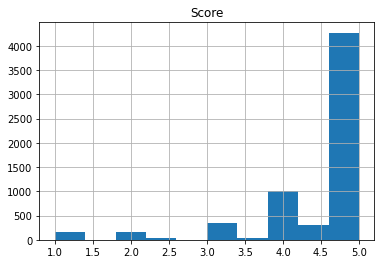

In [254]:
cleaned_df.hist()

### Clean Reviews

In [255]:
def remove_google_trans_comment(series):
    if "(Traduzido pelo Google)" in series:
        return series.replace("(Traduzido pelo Google) ","")
    else:
        return series    

In [256]:
cleaned_df.Review = cleaned_df.Review.apply(remove_google_trans_comment)

/home/jamie/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [257]:
cleaned_df.reset_index(drop=True)

,Restaurant,Score,When,Review
0,Darshan Nepal,4.5,há um mês,"Muito boa comida, boa garçonete de senhora. Pe..."
1,Darshan Nepal,4.0,há 3 meses,Voe para Lisboa se sentir falta da autêntica c...
2,Darshan Nepal,3.5,há 2 meses,Comida deliciosa e uma equipe muito simpática ...
3,Darshan Nepal,3.0,há um mês,"Muito boa comida, boa garçonete de senhora. Pe..."
4,Darshan Nepal,2.5,há 3 meses,Voe para Lisboa se sentir falta da autêntica c...
...,...,...,...,...
6305,Spice Hut Tandoori,4.0,há 3 anos,O melhor em qualidade e boas-vindas\n\n(Origin...
6306,Spice Hut Tandoori,5.0,há um ano,Bom
6307,Spice Hut Tandoori,4.0,há 3 anos,Tratamento impecável e comida imbatível\n\n(Or...
6308,Spice Hut Tandoori,5.0,há 4 anos,Super bom chefe\n\n(Original)\nPatron super sympa


## NLP preproc

In [258]:
good_scores = cleaned_df[ cleaned_df.Score >=4]

In [259]:
bad_scores = cleaned_df[ cleaned_df.Score <4]

In [260]:
def clean (text):
    
    for punctuation in string.punctuation:
        text = text.replace(punctuation, ' ') # Remove Punctuation
        
    lowercased = text.lower() # Lower Case
    
    #unaccented_string = unidecode.unidecode(lowercased) # remove accents
    
    tokenized = word_tokenize(lowercased) # Tokenize
    
    words_only = [word for word in tokenized if word.isalpha()] # Remove numbers
    
    stop_words = set(stopwords.words('english')) # Make stopword list
    
    without_stopwords = [word for word in words_only if not word in stop_words] # Remove Stop Words
    
    return " ".join(without_stopwords)

In [261]:
good_scores['cleaned_reviews'] = good_scores['Review'].apply(clean)
good_scores.head()

/tmp/ipykernel_565/1163277420.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  good_scores['cleaned_reviews'] = good_scores['Review'].apply(clean)


,Restaurant,Score,When,Review,cleaned_reviews
0,Darshan Nepal,4.5,há um mês,"Muito boa comida, boa garçonete de senhora. Pe...",muito boa comida boa garçonete de senhora pedi...
1,Darshan Nepal,4.0,há 3 meses,Voe para Lisboa se sentir falta da autêntica c...,voe para lisboa se sentir falta da autêntica c...
6,Darshan Nepal,4.4,há um mês,Que lugar ótimo para relaxar com comida tranqu...,que lugar ótimo para relaxar com comida tranqu...
7,Darshan Nepal,4.1,há uma semana,"The foods are delicious, the place is clean an...",foods delicious place clean staff super respec...
8,Darshan Nepal,4.1,há um mês,Boa comida e funcionários simpáticos. A comida...,boa comida e funcionários simpáticos comida er...


In [262]:
bad_scores['cleaned_reviews'] = bad_scores['Review'].apply(clean)
bad_scores.head()

/tmp/ipykernel_565/3365364549.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_scores['cleaned_reviews'] = bad_scores['Review'].apply(clean)


,Restaurant,Score,When,Review,cleaned_reviews
2,Darshan Nepal,3.5,há 2 meses,Comida deliciosa e uma equipe muito simpática ...,comida deliciosa e uma equipe muito simpática ...
3,Darshan Nepal,3.0,há um mês,"Muito boa comida, boa garçonete de senhora. Pe...",muito boa comida boa garçonete de senhora pedi...
4,Darshan Nepal,2.5,há 3 meses,Voe para Lisboa se sentir falta da autêntica c...,voe para lisboa se sentir falta da autêntica c...
5,Darshan Nepal,2.0,há 2 meses,Comida deliciosa e uma equipe muito simpática ...,comida deliciosa e uma equipe muito simpática ...
56,Darshan Nepal,3.0,há um ano,Um dos melhores restaurantes nepaleses de Lisb...,um dos melhores restaurantes nepaleses de lisb...


## Tfidf

In [263]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Tuned TFidfvectorizer
def Tfidf_fit(series):
    vec = TfidfVectorizer(ngram_range = (2,2), min_df=0.01, max_df = 0.05).fit(series)
    return vec

def transform_create_list(series):
    vectors = Tfidf_fit(series).transform(series) # Transform text to vectors

    sum_tfidf = vectors.sum(axis=0) # Sum of tfidf weighting by word

    tfidf_list = [(word, sum_tfidf[0, idx]) for word, idx in     Tfidf_fit(series).vocabulary_.items()]  # Get the word and associated weight

    sorted_tfidf_list =sorted(tfidf_list, key = lambda x: x[1], reverse=True)  # Sort

    return sorted_tfidf_list

In [264]:
Tfidf_fit(good_scores.cleaned_reviews)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.05, max_features=None,
                min_df=0.01, ngram_range=(2, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [265]:
transform_create_list(good_scores.cleaned_reviews)[:15]

[('muito boa', 176.8788889669308),
 ('em lisboa', 169.79401188416622),
 ('comida deliciosa', 140.31197471148948),
 ('excelente comida', 129.8684381650837),
 ('comida muito', 112.42729292987775),
 ('um pouco', 111.21700253475086),
 ('comida era', 105.59968651337506),
 ('este lugar', 87.97854965618677),
 ('muito bem', 87.74704357225889),
 ('de lisboa', 86.82240450120591),
 ('comida indiana', 84.93134215288596),
 ('ótima comida', 77.56544866294374),
 ('comida serviço', 72.84837763629325),
 ('serviço muito', 72.53103784935153),
 ('muito agradável', 72.44162466580072)]

In [266]:
Tfidf_fit(bad_scores.cleaned_reviews)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.05, max_features=None,
                min_df=0.01, ngram_range=(2, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [267]:
transform_create_list(bad_scores.cleaned_reviews)[:15]

[('comida deliciosa', 16.67136230411481),
 ('comida indiana', 16.04512887488765),
 ('um pouco', 15.90006884244471),
 ('muito bem', 14.181006997635555),
 ('de lisboa', 14.009779830278664),
 ('com um', 13.755132094811207),
 ('excelente comida', 13.466374624784518),
 ('serviço muito', 13.427579567297242),
 ('comida era', 12.834573646515905),
 ('este lugar', 12.5088287662679),
 ('altamente recomendado', 12.346122549468364),
 ('comida muito', 11.773115651177438),
 ('que já', 11.665563769615927),
 ('este restaurante', 11.322426940208327),
 ('um restaurante', 11.032450275137796)]

## Multibinomial

In [ ]:
cleaned_df